# 3.1 – K-Nearest Neighbors (KNN)

This notebook explains the K-Nearest Neighbors (KNN) algorithm, which is one of the simplest and most intuitive machine learning algorithms.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from ipywidgets import interact, IntSlider

cmap = 'seismic'
%config InlineBackend.figure_format = 'retina'

## 1. Dataset Overview

The dataset contains 3000 observations, each representing a patient. For each patient, we have measurements of two genes: `Gene One` and `Gene Two`. The values in future columns are continious real-valued values. 

The target variable is `Cancer Present`: A binary variable (0 or 1), where 0 indicates that patient is healty and 1 indicates he has cancer. Since the target variable column has only two values, this is a binary classification problem. The goal is to use the values of `Gene One` and `Gene Two` to predict whether a patient has cancer or not.

In [2]:
data = pd.read_csv('/Users/konansul/Desktop/course-ml/DATA/gene_expression.csv')

In [3]:
data

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1
...,...,...,...
2995,5.0,6.5,1
2996,3.4,6.6,0
2997,2.7,6.5,0
2998,3.3,5.6,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


In [5]:
data['Cancer Present'].value_counts()

Cancer Present
1    1500
0    1500
Name: count, dtype: int64

From the scatter plot of the data, we can visually observe that the samples fall into two distinct classes patients with and without cancer but the decision boundary is non-linear. This is an important observation when choosing the right classification algorithm. Some other classifiers, such as Logistic Regression**, which assumes a linear decision boundary, or even Support Vector Machines (SVM) without kernel tricks, may struggle to accurately separate the classes in this dataset due to its non-linear structure.

However, K-Nearest Neighbors is a non-parametric and instance-based learning algorithm. Instance-based means KNN makes predictions based on the entire training dataset and doesn't involve any explicit learning phase (like training weights in a neural network), that's why it called a lazy learning algorithm. Adittionalt it doesn't assume any specific form for the decision boundary. Instead, it classifies new points based on the local neighborhood of the training data. This makes KNN well-suited for datasets, where the boundary between classes is irregular or curved.

<Axes: xlabel='Gene One', ylabel='Gene Two'>

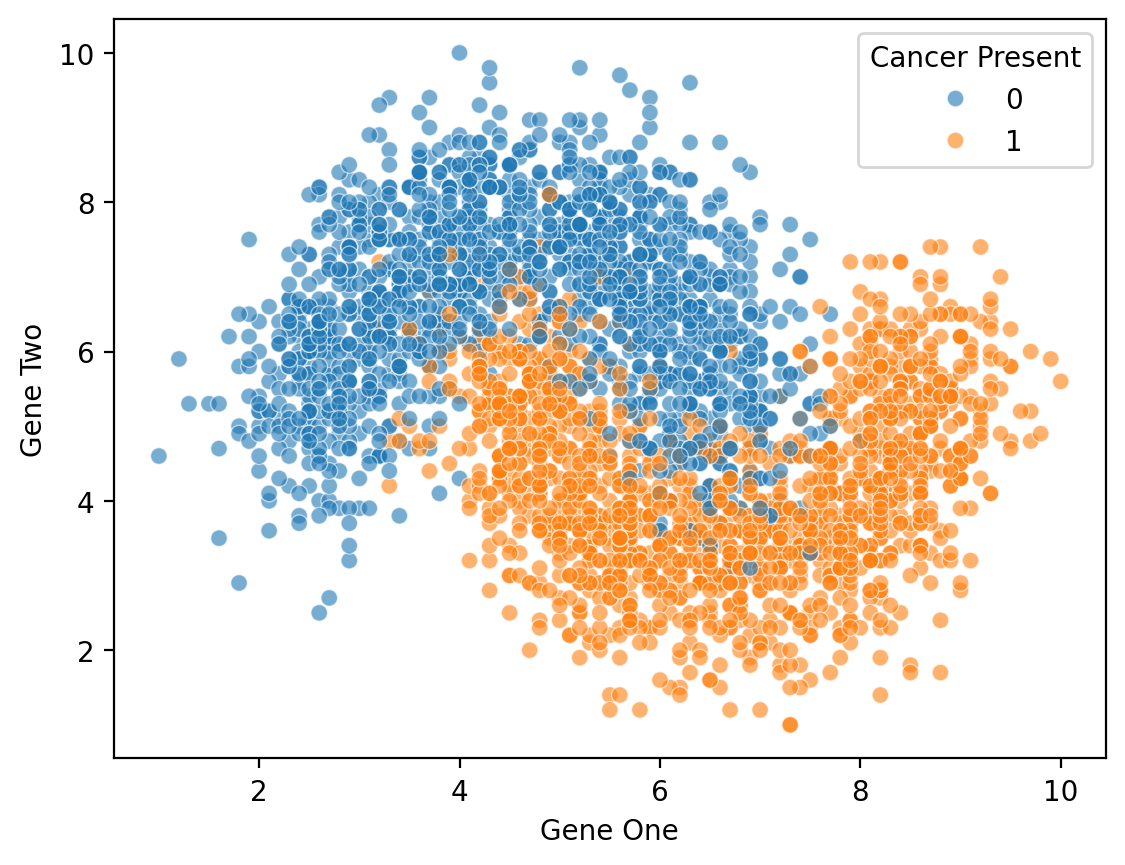

In [6]:
sns.scatterplot(x = 'Gene One', y = 'Gene Two', hue = 'Cancer Present', data = data, alpha = 0.6)

(4.0, 8.0)

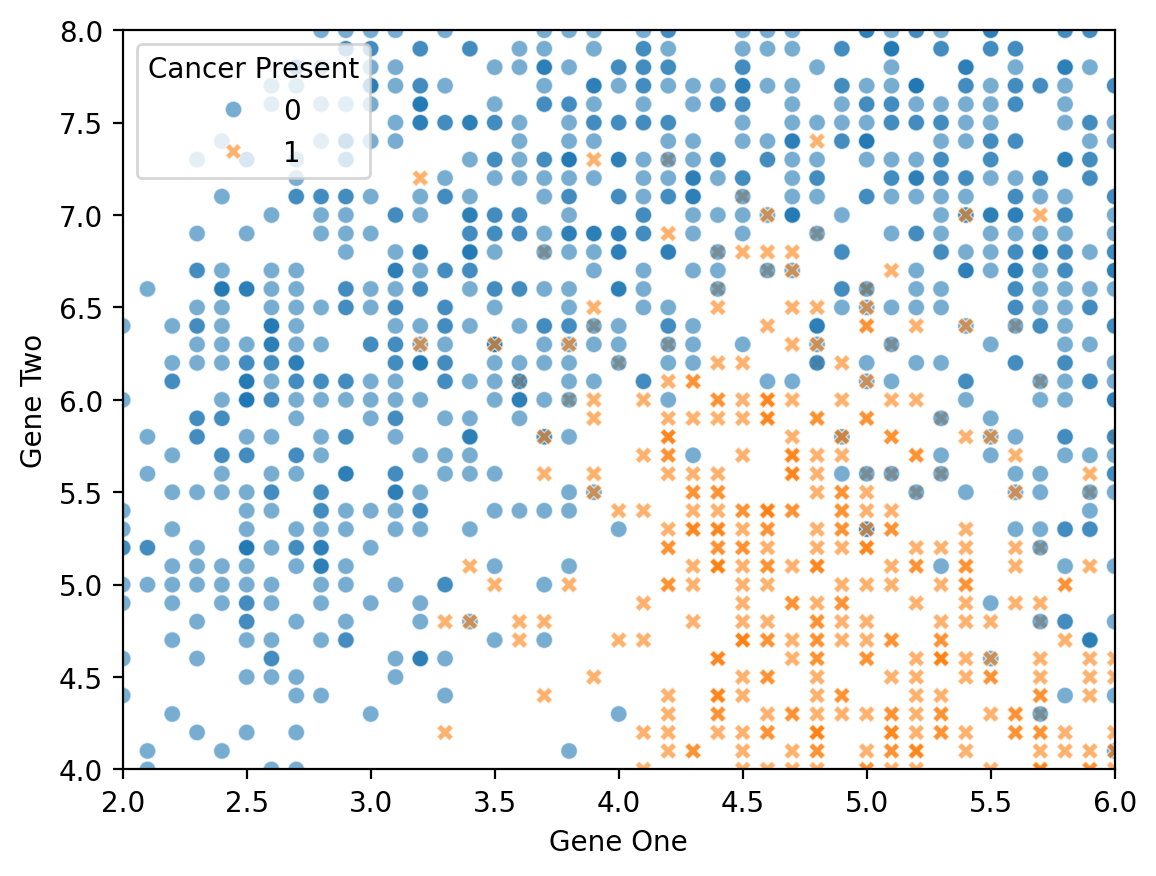

In [7]:
sns.scatterplot(x = 'Gene One', y = 'Gene Two', hue = 'Cancer Present', data = data, alpha = 0.6, style = 'Cancer Present')
plt.xlim(2,6)
plt.ylim(4,8)

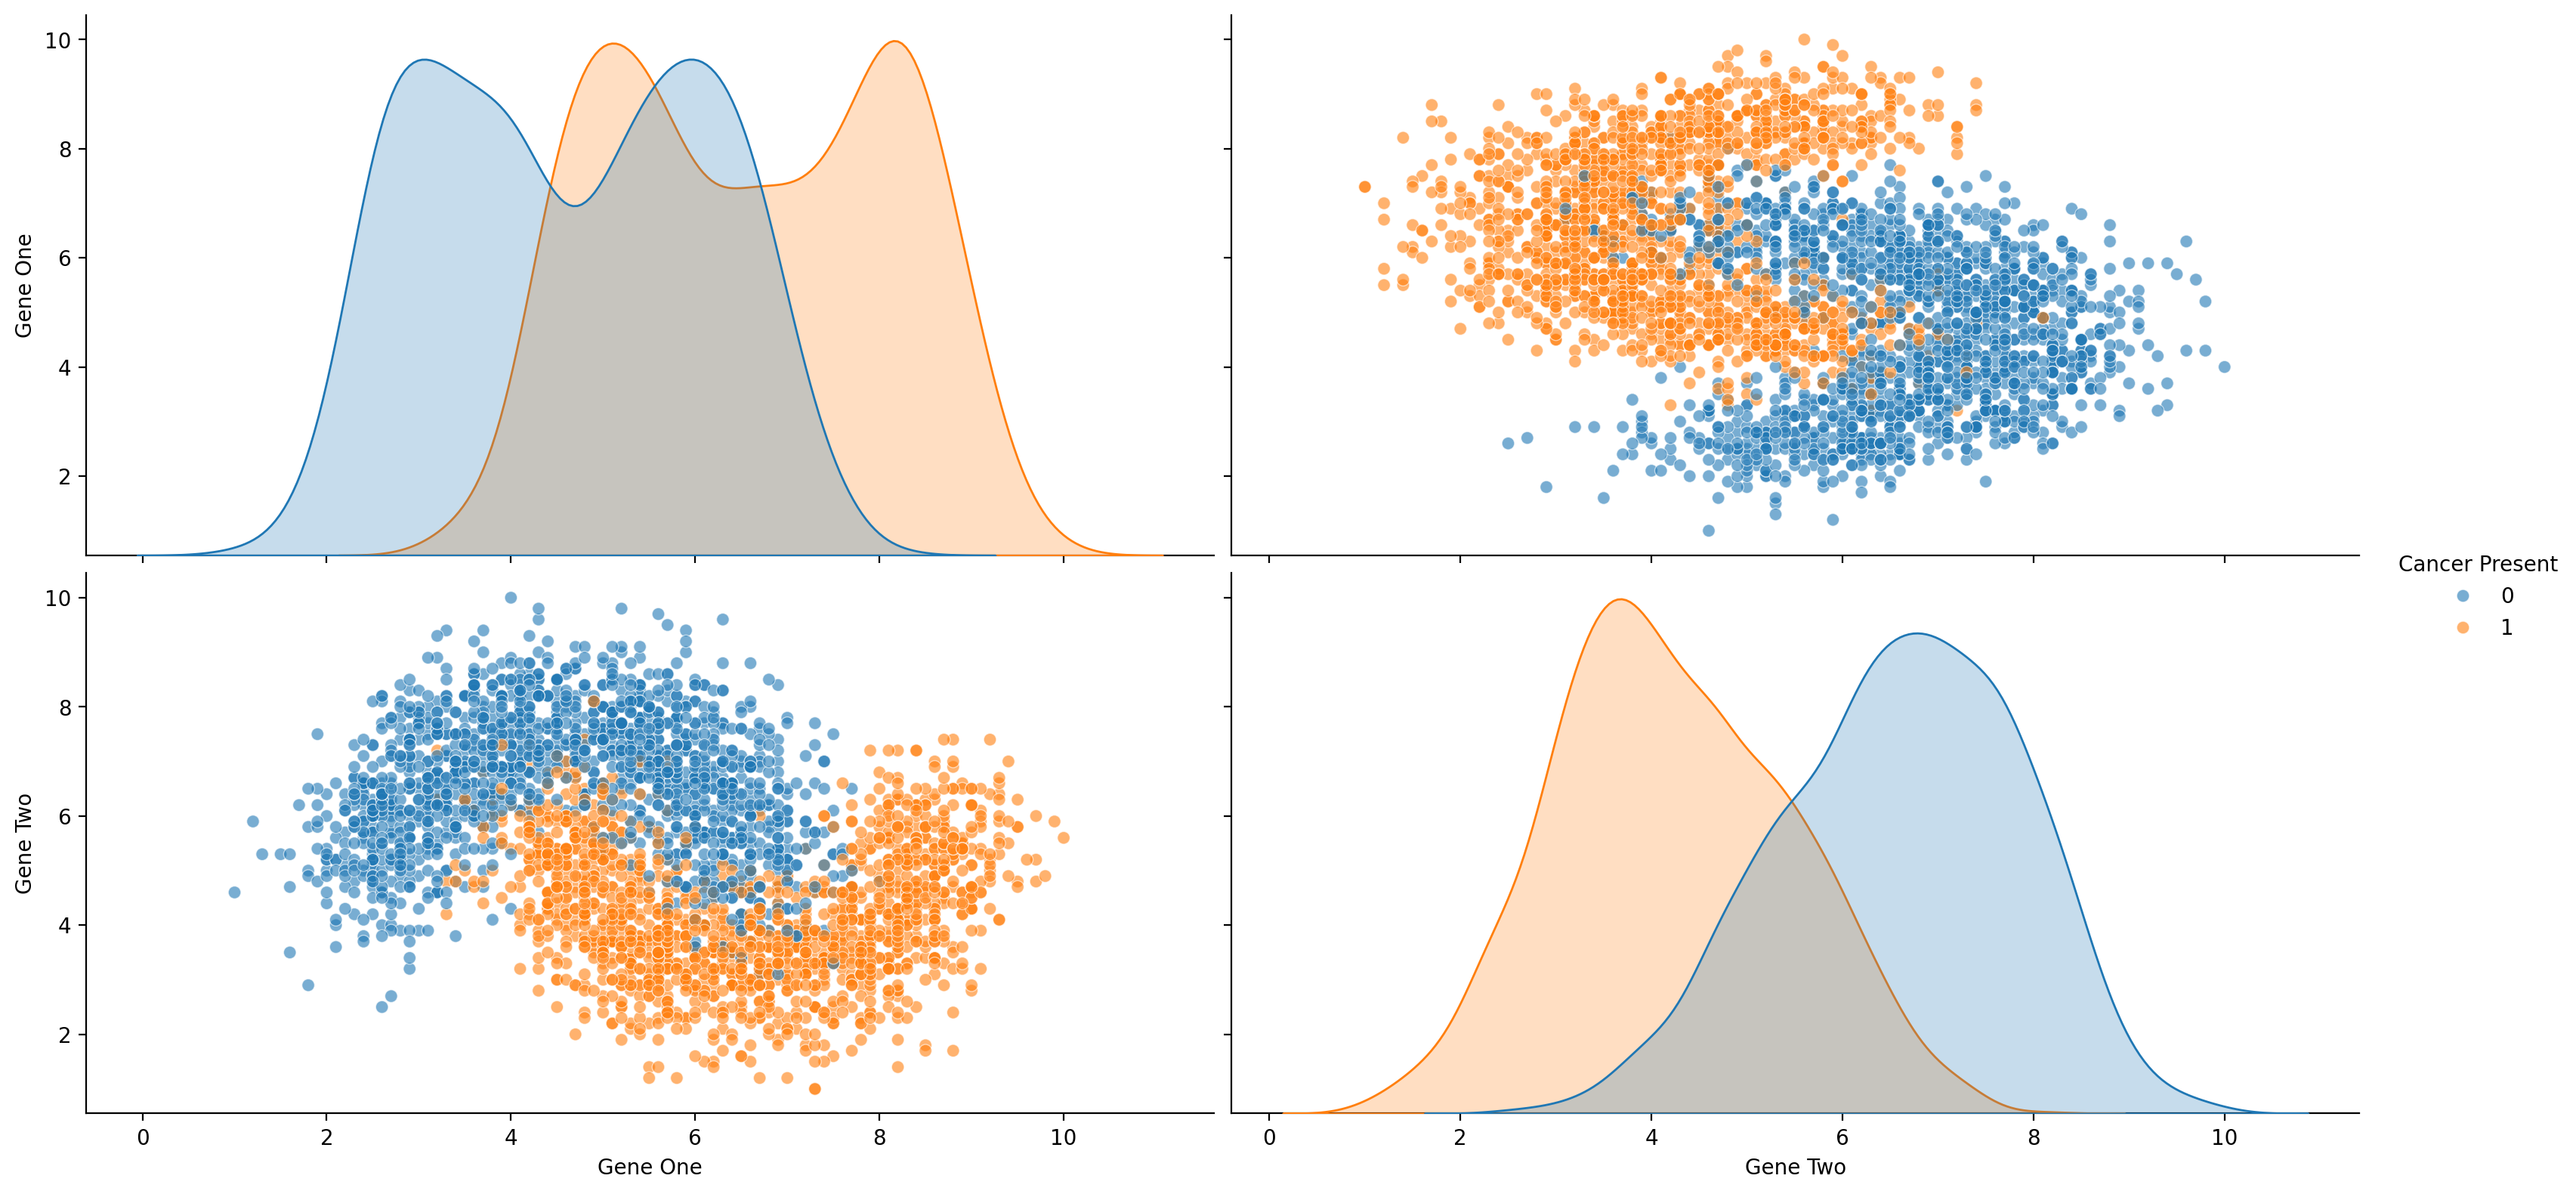

In [8]:
sns.pairplot(data, hue='Cancer Present', plot_kws={'alpha': 0.6}, height = 4, aspect=2)

## 2. Mathematical Explanation

The K-Nearest Neighbors (KNN) algorithm works based on distance and majority voting. Suppose we have a set of training points, each with known feature values and a known class label for example 0 and 1. Suppose we have a new point (unlabeled) and we want to predict which class it belongs to.

We compute the distance from this point to nearest points. For example we ca have 3000 points, but classify any point with 5 or 10 neighbors. This parameter in sckit-learn is `n_neighbors` and by default it is equal to 5. The most common distance metric is Euclidean distance which is, defined as:

$$
D(x, x_i) = \sqrt{(x_1 - x_{i1})^2 + (x_2 - x_{i2})^2}
$$

where $x$ is the new point and $x_i$ is a point in the training data. We then select the k closest points to our new point. These are the k-nearest neighbors.

However, other distance metrics can also be used depending on the nature of the data or the problem like Manhattan Distance, Chebyshev Distance, Minkowski Distance and others. We check the class labels of these k neighbors and perform majority voting. The class that occurs most frequently among the neighbors is assigned to the new point.

Suppose we have a new point and `k = 5`. The 5 closest points are: 3 points from Class 0, and 2 points from Class 1. In this case, the new point is classified as Class 0, because it has more neighbors from Class 0 than Class 1.

We can also calculate the probability that the new point belongs to each class:

$$
P(\text{Class } j \mid x) = \frac{\text{Number of neighbors in Class } j}{k}
$$

In our example: this new point to every point in the training dataset

$$ P(\text{Class } 0) = \frac{3}{5} = 0.6 $$
$$ P(\text{Class } 1) = \frac{2}{5} = 0.4 $$

So, the model not only predicts Class 0, but also gives a 60% confidence for Class 0 and 40% confidence** for Class 1.


The our dataset we used 2 features, which means our data points lie in 2-dimensional space. But KNN can naturally be extended to higher dimensions. Every time we add a new feature (or column), we increase the dimensionality of the space by 1. For example with 3 features, we are in 3D space, with 4 features, we move into 4D space and so on. The Euclidean distance formula automatically adapts to higher dimensions by summing the squared differences across all features:

$$
D(x, x_i) = \sqrt{(x_1 - x_{i1})^2 + (x_2 - x_{i2})^2 + \dots + (x_n - x_{in})^2}
$$

However, it's important to be aware of the curse of dimensionality: as the number of dimensions increases, distances between points tend to become less meaningful, and KNN performance may degrade. That’s why feature selection or dimensionality reduction (like PCA) is often applied before using KNN on high-dimensional data.

## 3. Model Training

In [9]:
X = data.drop('Cancer Present', axis = 1)

In [10]:
y = data['Cancer Present']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [12]:
scaler = StandardScaler()

In [13]:
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_test = scaler.transform(X_test)

In [14]:
knn_model = KNeighborsClassifier(n_neighbors = 1)

In [15]:
knn_model.fit(scaled_x_train, y_train)

,n_neighbors,1
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [16]:
y_pred = knn_model.predict(scaled_x_test)

In [17]:
y_pred[:100]

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0])

## 4. Model Performance

In [18]:
def plot_metrics(model, x_test, y_test):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    ConfusionMatrixDisplay.from_estimator(model, x_test, y_test, cmap = 'Blues', ax = axes[0])
    RocCurveDisplay.from_estimator(model, x_test, y_test, ax = axes[1])
    PrecisionRecallDisplay.from_estimator(model, x_test, y_test, ax = axes[2])
    axes[0].set_title("Confusion Matrix")
    axes[1].set_title("ROC Curve")
    axes[2].set_title("Precision-Recall Curve")
    plt.tight_layout()
    plt.show()

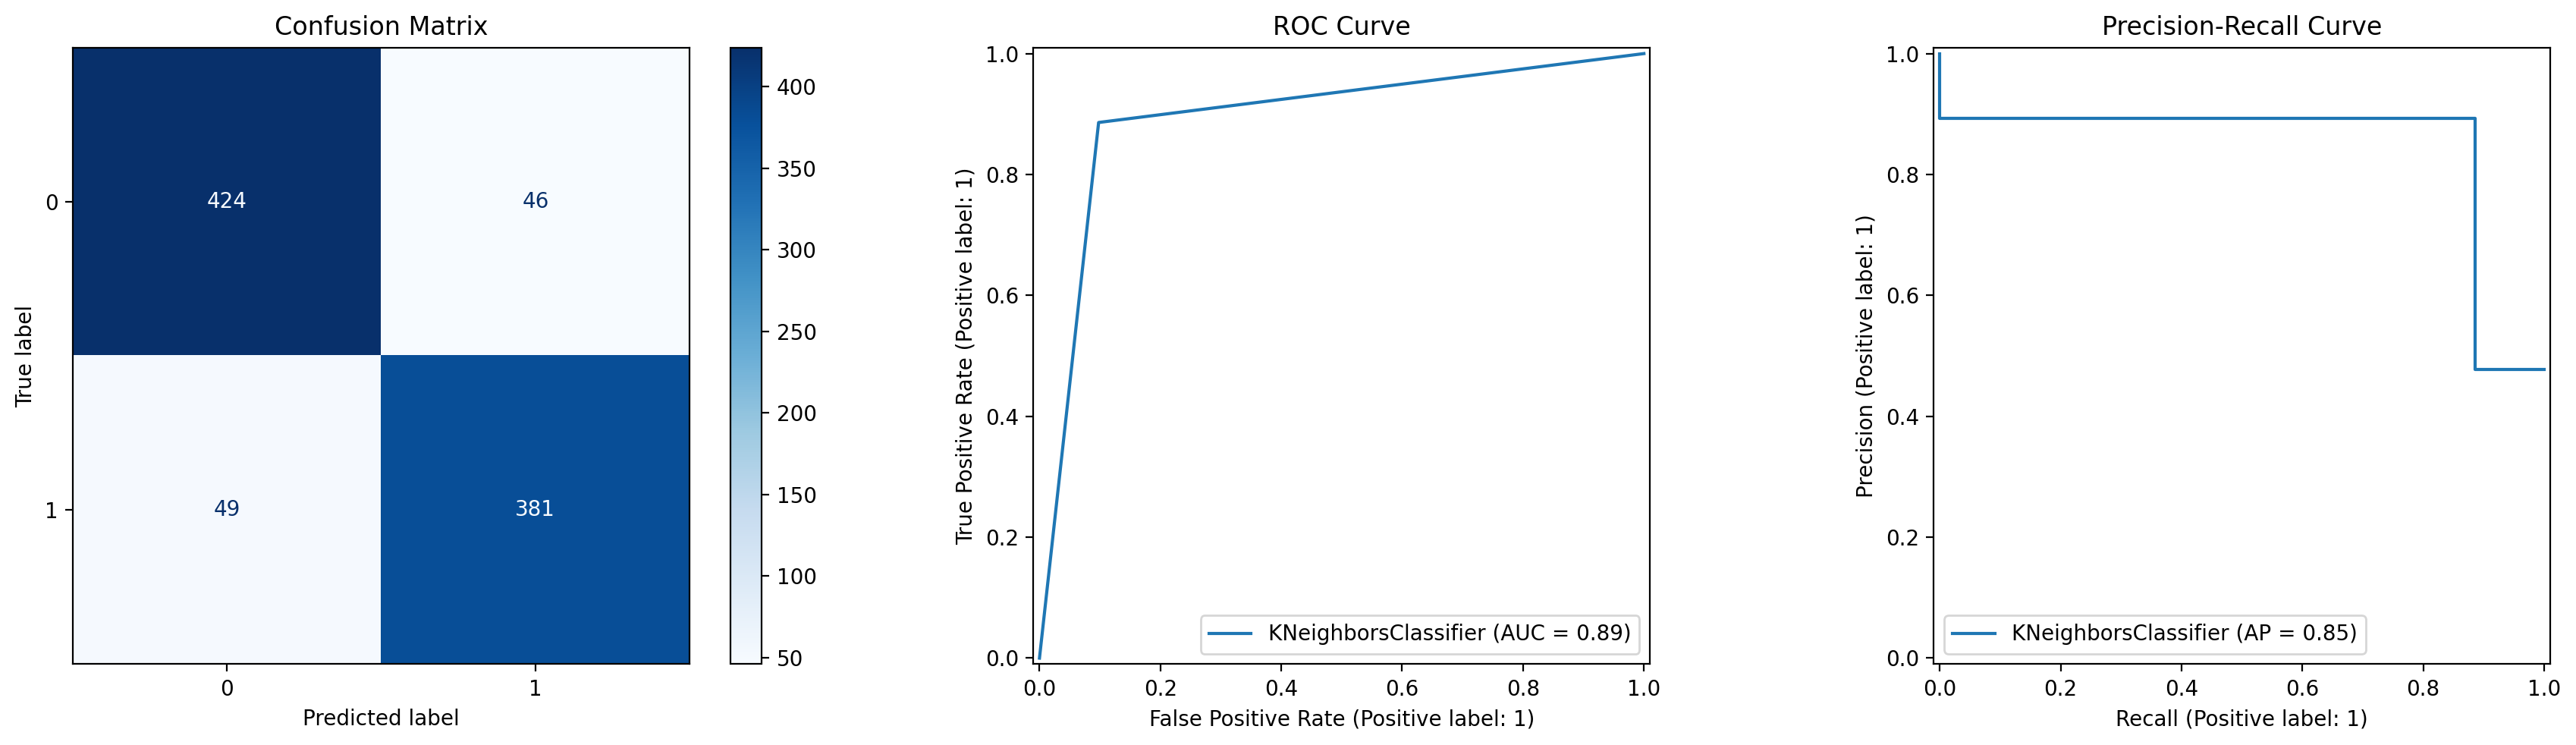

In [19]:
plot_metrics(knn_model, scaled_x_test, y_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       470
           1       0.89      0.89      0.89       430

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



## 5. Choosing the right value of K

If $k$ is too small,for exammple $ k = 1 $, model becomes too sensitive to noise. It may overfit and make unstable predictions.

If $k$ is too large, like $k = 100$ the model becomes too smooth, so it can underfit, ignoring important local patterns.

The objective is to find a value of $k$ that minimizes the error on unseen data. A common metric for error is:

$$
\text{Error} = 1 - \text{Accuracy Score}
$$

### Importance of Minimizing False Negatives
We can also analyze the confusion matrix to understand specific types of errors. In medical prediction tasks like cancer detection in our case, false negatives are especially dangerous. A false negative (FN) means the model predicts "no cancer" when the patient actually has cancer. This is also known as a **Type II error**. In many real-world applications, minimizing false negatives is more important than maximizing overall accuracy.

We can write a loop that evaluates model accuracy and error for values of $k$ from 1 to 100 and then visualize errors for each metrics. Or we can use an interactive slider (e.g., with `ipywidgets`) to dynamically see how metrics like accuracy, precision, recall, false negatives**, and confusion matrix change as $k$ varies. 

In [21]:
test_error_rates = [ ]

In [22]:
for k in range(1, 50):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(scaled_x_train, y_train)
    y_pred = knn.predict(scaled_x_test)

    errors = 1 - accuracy_score(y_test, y_pred)
    test_error_rates.append(errors)

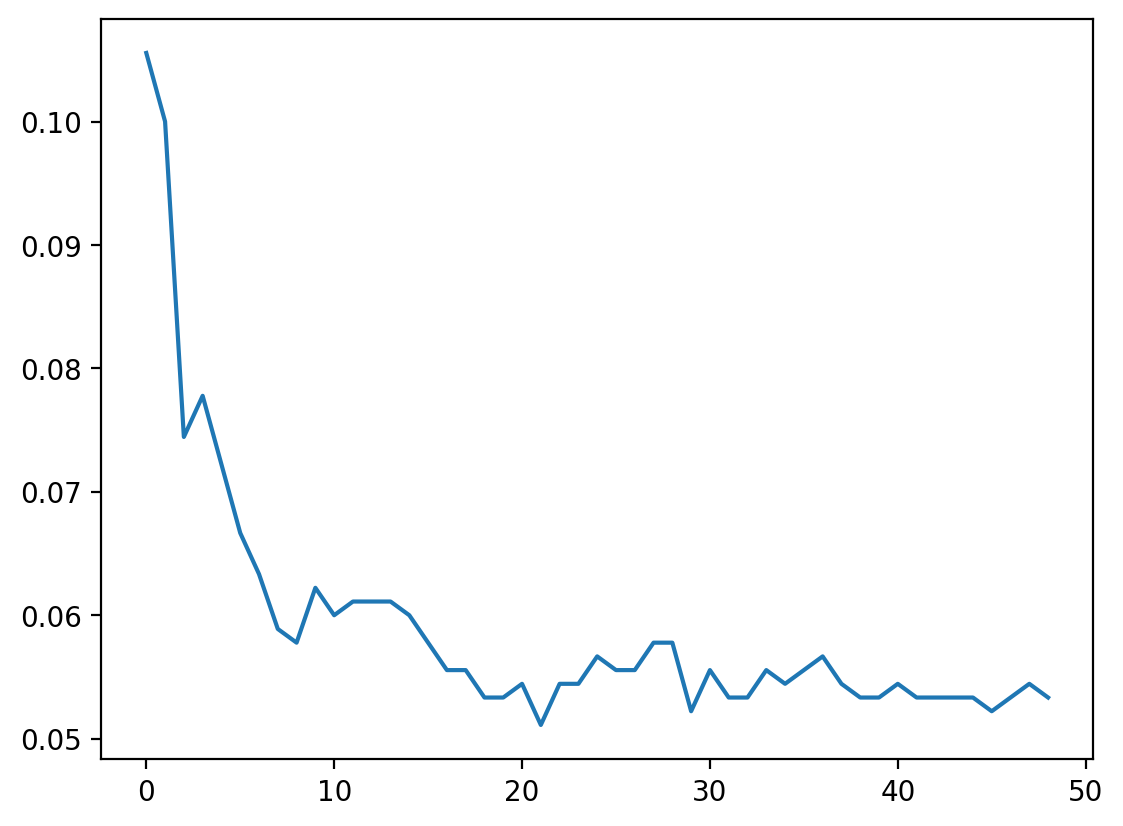

In [23]:
plt.plot(test_error_rates)

In [24]:
np.min(test_error_rates)

np.float64(0.05111111111111111)

(0.0, 0.11)

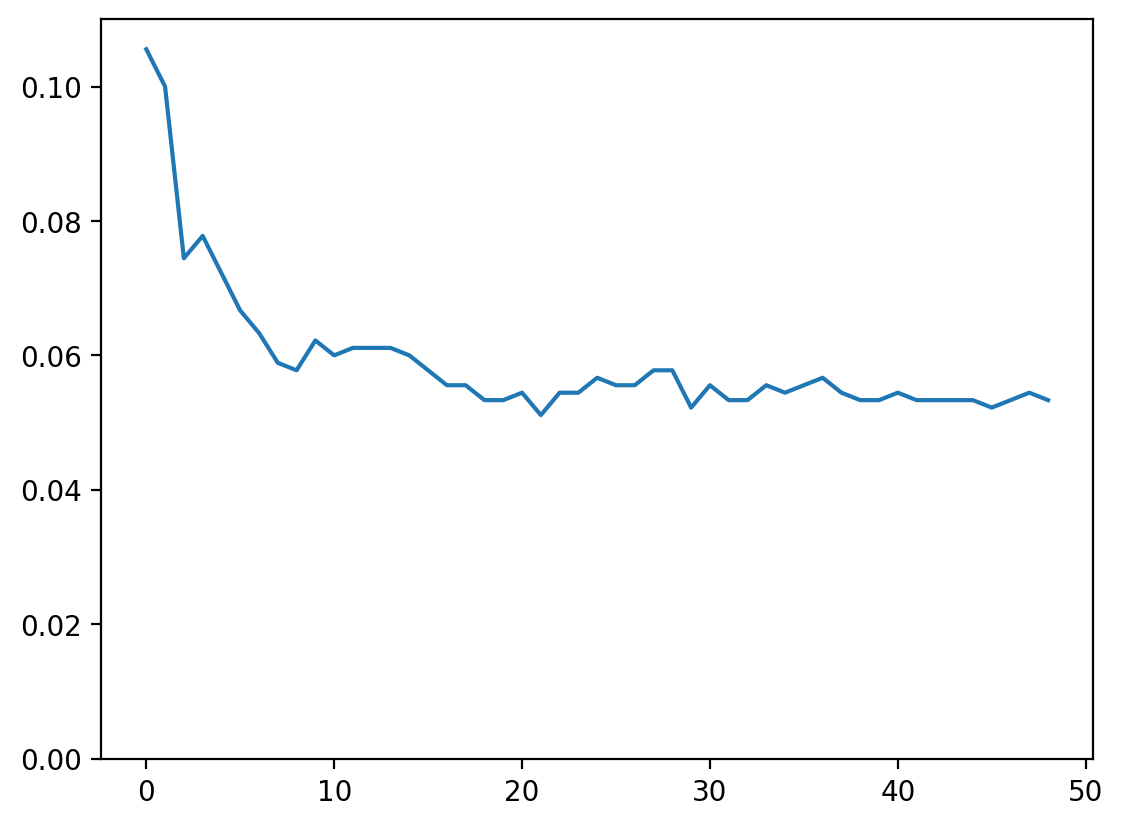

In [25]:
plt.plot(test_error_rates)
plt.ylim(0, 0.11)

In [26]:
def plot_confusion(k):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(scaled_x_train, y_train)
    y_pred = knn.predict(scaled_x_test)

    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (k = {k})")
    plt.show()

interact(plot_confusion, k = IntSlider(min=1, max=100, step=1, value=5))

interactive(children=(IntSlider(value=5, description='k', min=1), Output()), _dom_classes=('widget-interact',)…

<function __main__.plot_confusion(k)>

Another way to find the best value of $k$ is to use GridSearchCV a built-in method in `scikit-learn`. Grid Search automates the search for the best hyperparameters (like $k$ in KNN). It splits the training data into multiple folds (cross-validation), then trains and evaluates the model on each fold for every candidate $k$, finally it chooses the $k$ value that results in the lowest average error or highest accuracy.

In [27]:
scaler = StandardScaler()

In [28]:
knn = KNeighborsClassifier()

In [29]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [30]:
operations = [('scaler', scaler), ('knn', knn), ]

In [31]:
pipeline = Pipeline (operations)

In [32]:
k_values = list(range(1, 30))

In [33]:
parameter_grid = {'knn__n_neighbors': k_values}

In [34]:
grid_model = GridSearchCV(pipeline, parameter_grid, cv = 10, scoring = 'accuracy')

In [35]:
grid_model.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'knn__n_neighbors': [1, 2, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [36]:
grid_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=21))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=21),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 21,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [37]:
full_pred = grid_model.predict(X_test)

In [38]:
print(classification_report(y_test, full_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       470
           1       0.95      0.93      0.94       430

    accuracy                           0.95       900
   macro avg       0.95      0.95      0.95       900
weighted avg       0.95      0.95      0.95       900



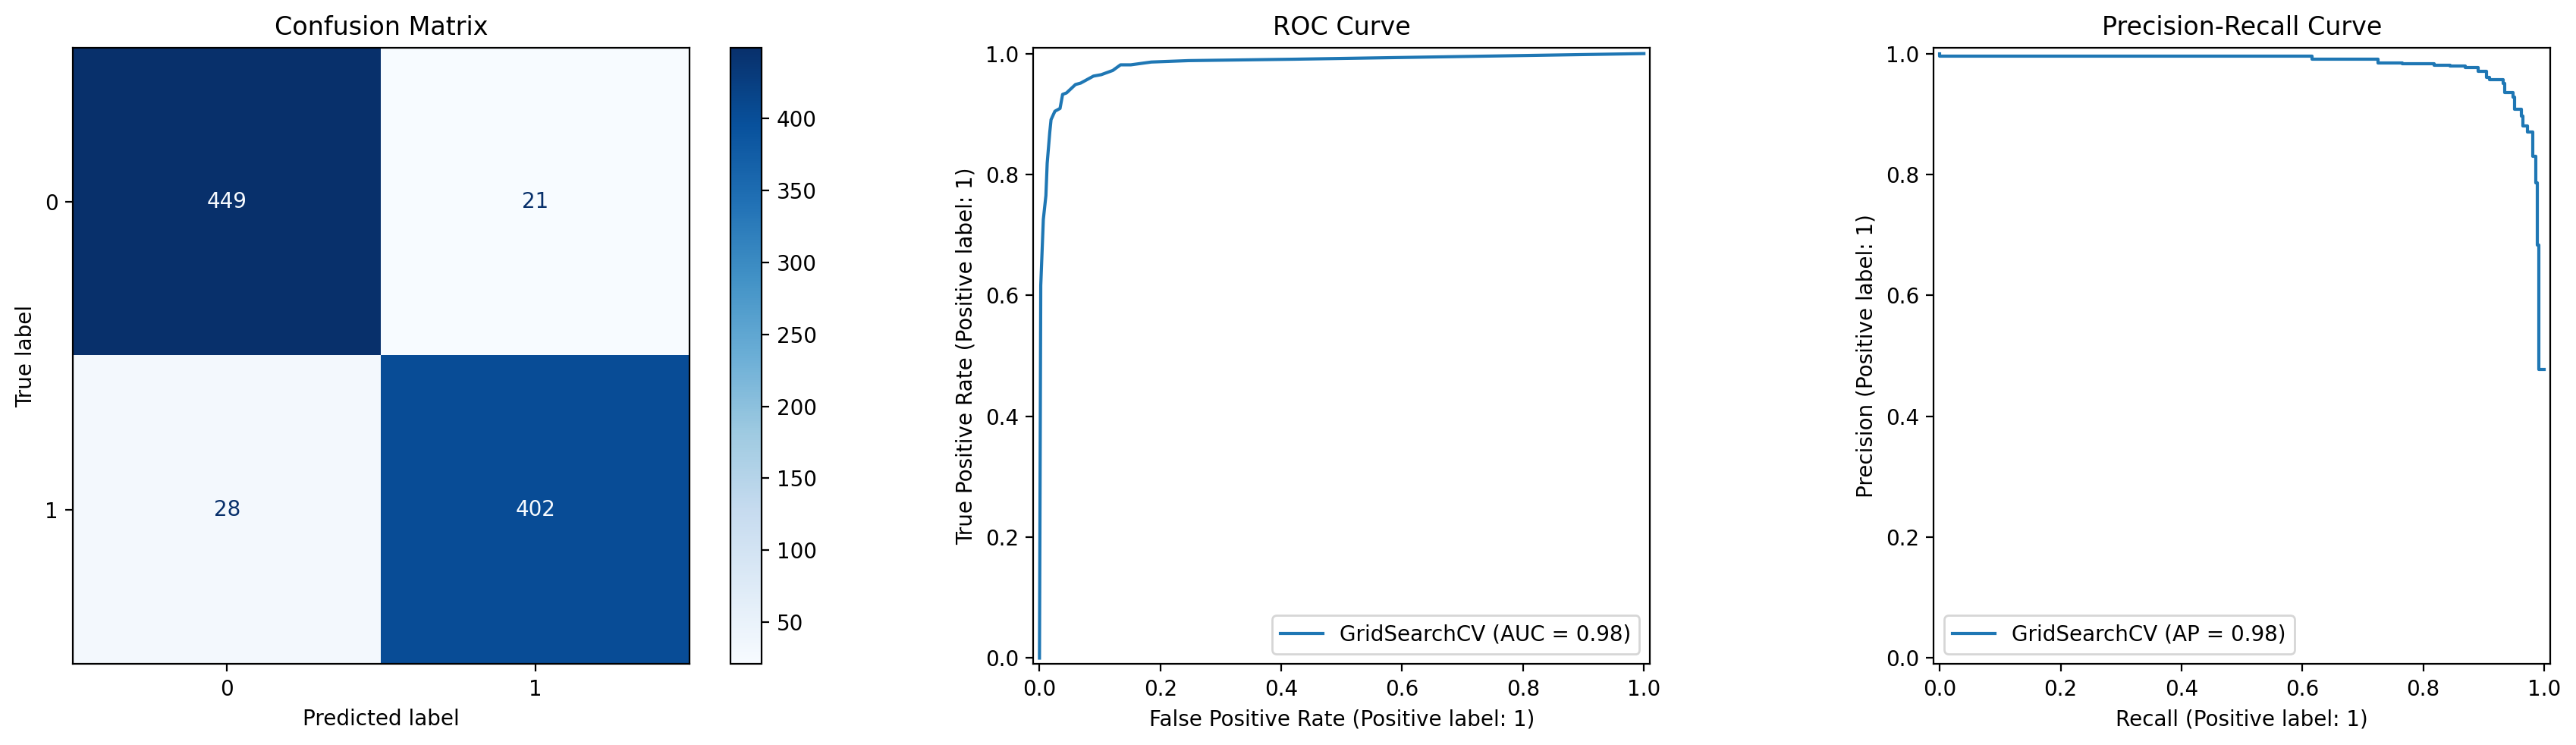

In [39]:
plot_metrics(grid_model, X_test, y_test)

## 6. References
**[1]** https://www.kaggle.com/datasets/brsahan/genomic-data-for-cancer